In [1]:
import scipy.ndimage as nd
import os
import numpy as np

import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3))
background_color = np.float32([200.0, 200.0, 200.0])
gen_image = np.random.normal(background_color, 8, (224, 224, 3))

def preprocess(img):
    return (img - vgg_mean)[:,:,::-1] #np.float32(np.rollaxis(img, 2)[::-1]) - vgg_mean
def deprocess(img):
    return (img + vgg_mean[:,:,::-1])[:,:,::-1] # to rgb again

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name(layer)

def blur(img, sigma):
    if sigma > 0:
        img[:,:,0] = nd.filters.gaussian_filter(img[:,:,0], sigma, order=0)
        img[:,:,1] = nd.filters.gaussian_filter(img[:,:,1], sigma, order=0)
        img[:,:,2] = nd.filters.gaussian_filter(img[:,:,2], sigma, order=0)
    return img

def render_naive_blur_clip(t_obj, img0=gen_image, iter_n=32,norm_param=1e-9,
                      start_step_size=1.5,end_step_size=1.5,
                      start_sigma=0.5, end_sigma=0.5,
                      clip=True):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = preprocess(img0.copy())
    img = np.expand_dims(img,0)
    w_, h_ = img.shape[1],img.shape[2]
    for i in range(iter_n): 
        g, score = sess.run([t_grad, t_score], {t_input:img, is_training:False})
        step = start_step_size + end_step_size - start_step_size * i / iter_n
        img += step/np.abs(g).mean()*g
        if clip:
            bias = vgg_mean
            img = np.clip(img, -bias, 255-bias)
        sigma = start_sigma + end_sigma - start_sigma * i / iter_n
        img[0] = blur(img[0], sigma)
    a = deprocess(img[0])
    if not clip:
        a = a*(255.0/np.percentile(a, 99.98))
    a = np.uint8(np.clip(a,0,255))#np.clip(a, 0, 1)*255)
    a = np.reshape(a, [w_, h_,3])
    return a

In [5]:
cdd_n, cnn_v = 5,''
epoch = 56
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)

t_input = tf.placeholder(tf.float32, name='input') # define the input tensor

saver = tf.train.import_meta_graph('/users/jmy/data/nets/16_class/VGG_Base/cdd_{}{}/net-{}.ckpt.meta'.format(str(cdd_n).zfill(2),cnn_v,str(epoch-1)),
                                       input_map={"Placeholder:0": t_input})
saver.restore(sess, '/users/jmy/data/nets/16_class/VGG_Base/cdd_{}{}/net-{}.ckpt'.format(str(cdd_n).zfill(2),cnn_v,str(epoch-1)))
is_training = graph.get_tensor_by_name("Placeholder_2:0")

layer = 'fc8/Conv2D:0'

INFO:tensorflow:Restoring parameters from /users/jmy/data/nets/16_class/VGG_Base/cdd_05/net-55.ckpt


# Class visualization
- visualize-VGGS-filters

In [6]:
params = [{'iter_n':200,
        'start_sigma':2.5,
        'end_sigma':1.1,
        'start_step_size':12.*0.25,
        'end_step_size':10.*0.25,
    },
    {
        'iter_n':100,
        'start_sigma':1.1,
        'end_sigma':0.78*1.1,
        'start_step_size':10.*0.25,
        'end_step_size':8.*0.25
    },
    {
        'scale':1.05,
        'iter_n':100,
        'start_sigma':0.78*1.1,
        'end_sigma':0.78,
        'start_step_size':8.*0.25,
        'end_step_size':6.*0.25
    },
    {
        'scale':1.05,
        'iter_n':50,
        'start_sigma':0.78*1.1,
        'end_sigma':0.40,
        'start_step_size':6.*0.25,
        'end_step_size':1.5*0.25
    },
    {
        'scale':1.05,
        'iter_n':25,
        'start_sigma':0.4,
        'end_sigma':0.1,
        'start_step_size':1.5*0.25,
        'end_step_size':0.5*0.25
    }]

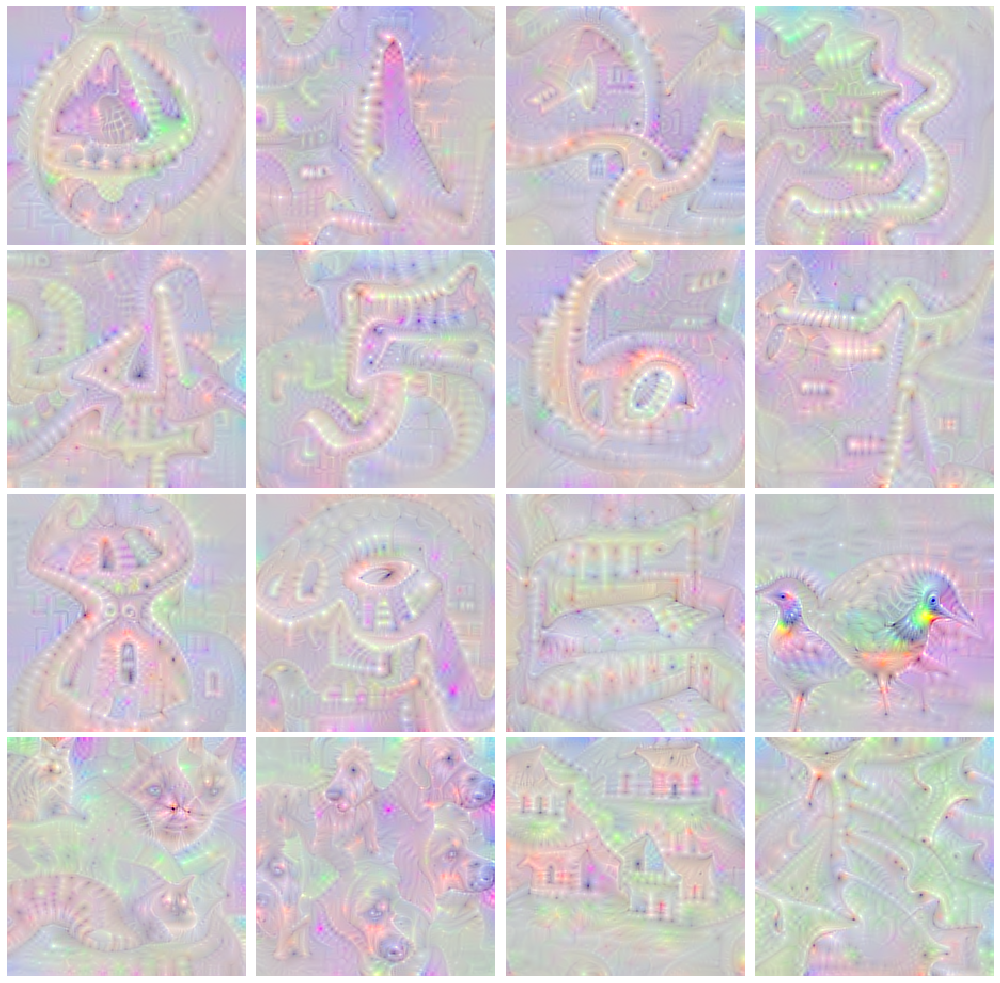

In [7]:
itern_tmp = len(params)
f,axes = plt.subplots(4,4, figsize=(14,14))
ax = axes.flat
for i in range(16):
    imgtmp = gen_image.copy()
    for itern in range(itern_tmp-1):
        imgtmp = render_naive_blur_clip(T(layer)[:,:,:,i],iter_n=params[itern]['iter_n'],
                                        img0=imgtmp,start_sigma=params[itern]['start_sigma'],
                                        end_sigma=params[itern]['end_sigma'],
                                        start_step_size=params[itern]['start_step_size'],
                                        end_step_size=params[itern]['end_step_size'])
    ax[i].imshow(render_naive_blur_clip(T(layer)[:,:,:,i],iter_n=params[itern_tmp-1]['iter_n'],img0=imgtmp,
             start_sigma=params[itern_tmp-1]['start_sigma'],end_sigma=params[itern_tmp-1]['end_sigma'],
             start_step_size=params[itern_tmp-1]['start_step_size'],end_step_size=params[itern_tmp-1]['end_step_size']))
    ax[i].axis('off')
    plt.tight_layout()
plt.show()

# Conv filters

In [ ]:
convs = [op.name for op in tf.get_default_graph().get_operations() if op.type=='Conv2D']
convs = convs[:-1]

In [ ]:
# Set 1
start_sigma, end_sigma = 0.78, 0.78*0.8
start_step_size, end_step_size = 3., 3.
iter_n = 200
for li in range(14):
    layer = convs[li] +':0'
    tmp = T(layer)
    nof = int(tmp.shape[-1])
    fn_list = random.sample(range(nof),16)
    f,axes = plt.subplots(4,4, figsize=(14,14))
    ax = axes.flat
    for ai in range(16):
        fi = fn_list[ai]
        ax[ai].set_title('Feature '+str(fi+1),fontsize=15)
        ax[ai].imshow(render_naive_blur_clip(T(layer)[:,:,:,fi],
                        img0=gen_image,iter_n=iter_n,
                     start_sigma=start_sigma,end_sigma=end_sigma,
                     start_step_size=start_step_size,end_step_size=end_step_size))
        ax[ai].axis('off')
        plt.tight_layout()
    f.savefig(base+'/Figure/AM/Single_CNN_Cdd_05/Feature/Deep/'+convs[li].split('/')[1]+'_set1.jpg')
    plt.close()

In [ ]:
# Set 2
for li in range(14):
    layer = convs[li] +':0'
    tmp = T(layer)
    nof = int(tmp.shape[-1])
    fn_list = random.sample(range(nof),16)
    f,axes = plt.subplots(4,4, figsize=(14,14))
    ax = axes.flat
    for ai in range(16):
        fi = fn_list[ai]
        ax[ai].set_title('Feature '+str(fi+1),fontsize=15)
        tmp_ = render_naive_blur_clip(T(layer)[:,:,:,fi],iter_n=500,
         start_sigma=2.5,end_sigma=0.78,
         start_step_size=2.,end_step_size=2.)
        ax[ai].imshow(render_naive_blur_clip(T(layer)[:,:,:,fi],iter_n=500,img0=tmp_,
         start_sigma=2.5*0.5,end_sigma=0.78*0.5,
         start_step_size=1.,end_step_size=1.))
        ax[ai].axis('off')
        plt.tight_layout()
    f.savefig(base+'/Figure/AM/Single_CNN_Cdd_05/Feature/Deep/'+convs[li].split('/')[1]+'_set2.jpg')
    plt.close()